# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 0.5 Load the sign names xref

In [2]:
#load xref for sign names
with open('signnames.csv', 'rb') as f:
    sign_names_data = str(f.read())
    
#would normally use pandas or csv module but figured this would be fine for the small file size
ID_TO_NAME = dict( (int(v[0]),v[1]) for v in map(lambda x: x.split(','), sign_names_data.split('\\n')) if len(v)>1 and v[0].isdigit()) 
del sign_names_data

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len( set(y_train) | set(y_test) )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


def bounding_box(org_size,box):
    '''convert the bounding box to image units'''
    #original size
    w,h= org_size
    #our current is size (32,32)
    w_scale = 32.0/w
    h_scale = 32.0/h
    x1,y1,x2,y2 = box
    return [x1*w_scale,y1*h_scale,x2*w_scale,y2*h_scale]
    
def draw_bounding_box(box, ax):
    '''draw the bounding box'''
    x1,y1,x2,y2 = box
    w=x2-x1
    h=y2-y1
    
    ax.add_patch(
        patches.Rectangle(
            (x1, y1),
            w,
            h,
            fill=False,      # remove background
            edgecolor = '#00ff00'
        )
    )

def plot_random_train_sign_sample(N):
    idx = np.random.permutation(range(len(X_train)))[:N]
    
    w=5
    off =0
    if N%5 !=0:
        off = 1
        
    h = N/5 +off
    
    fig = plt.figure(figsize=(w*2.5,h*2.5*.7))

    for j,i in enumerate(idx):
        plt.subplot(h ,w,j+1)

        x0=X_train[i]
        plt.imshow(x0)
        plt.title(ID_TO_NAME[y_train[i]])

        
        ax = plt.gca()
        try:
            box=bounding_box(train['sizes'][i],train['coords'][i])
            draw_bounding_box(box,plt.gca())
        except:
            pass
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.tight_layout(pad=0.0)

In [5]:
sn.set_style("whitegrid", {'axes.grid' : False})

%matplotlib inline

In [6]:
from scipy.ndimage.interpolation import zoom, rotate, shift

def zoom_clip(img, zoom_factor):
    zoomed = zoom(img,(zoom_factor,zoom_factor,1), mode='nearest',order=1)
    offset=int( (zoomed.shape[0] - 32)/2)
    zoomed = zoomed[offset:offset+32,offset:offset+32]
    return zoomed
    
def generate_image(i,MAX_ROTATE=15, MAX_SHIFT=4):
    img=X_train[i]
    box = bounding_box(train['sizes'][i],train['coords'][i])

    #shift the image, we first calculate the maximum amount we can shift in any direction
    xr,xl = int(box[0]),int(32-box[2])
    yt,yb = int(box[1]),int(32-box[3])
    
    xr=min(xr,MAX_SHIFT)
    xl=min(xr,MAX_SHIFT)
    yt=min(xr,MAX_SHIFT)
    yb=min(xr,MAX_SHIFT)
    
    y_shift=np.random.choice(np.arange(-yt,yb,1)) if yt+yb !=0 else 0
    x_shift=np.random.choice(np.arange(-xr,xl,1)) if xr+xl !=0 else 0
    box[0]+=x_shift
    box[2]+=x_shift
    box[1]+=y_shift
    box[3]+=y_shift

    img=shift(X_train[i],[y_shift,x_shift,0],mode='nearest')

    #maybe rotate
    rot_angle = 2*(np.random.rand()-.5)*MAX_ROTATE
    img=rotate(img,rot_angle,reshape=False,mode='nearest')

    #maybe zoom?
    max_offset = 2*min([box[0],box[1],32-box[2],32-box[3]])
    max_zoom = (max_offset+32) / 32

    zoom_factor =  1+np.random.rand()*(max_zoom-1)
    img=zoom_clip(img,zoom_factor)

    return img


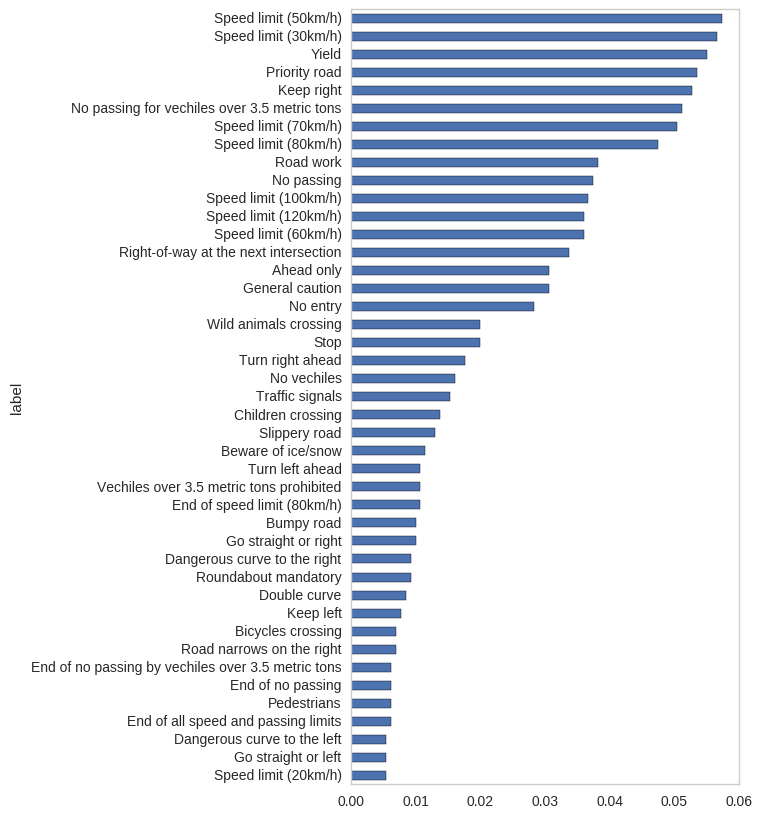

In [7]:
import pandas as pd

#check the lable balance
ids, qty = np.unique(y_train, return_counts=True)

df = pd.DataFrame(list(zip(ids,qty)), columns=['id','qty'])
df['label']=df.id.apply(lambda x: ID_TO_NAME[x])
df['p']=df.qty/df.qty.sum()

fig=plt.figure(figsize=(5,10))
df.set_index('label').sort_values('p').p.plot(kind='barh', ax=plt.gca())

In [8]:
#split the images into to categories by their label id
cats=dict([i,[]] for i in set(y_train))

for i in range(len(y_train)):
    cats[y_train[i]].append(i)

In [9]:
NUM_PER_CAT = 3000#df.qty.max()

In [10]:
%%time

np.random.RandomState(42)

new_x = []
new_y=[]

for k in cats:
    N = NUM_PER_CAT - len(cats[k])
    print(ID_TO_NAME[k],N)
    for _ in range(N):
        i = np.random.choice(cats[k])
        img = generate_image(i)
        if img.shape ==(32,32,3):
            new_x.append(img)
            new_y.append(k)

print('generated {} new images'.format(len(new_y)))

Speed limit (20km/h) 2790


/home/chris/anaconda2/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Speed limit (30km/h) 780
Speed limit (50km/h) 750
Speed limit (60km/h) 1590
Speed limit (70km/h) 1020
Speed limit (80km/h) 1140
End of speed limit (80km/h) 2580
Speed limit (100km/h) 1560
Speed limit (120km/h) 1590
No passing 1530
No passing for vechiles over 3.5 metric tons 990
Right-of-way at the next intersection 1680
Priority road 900
Yield 840
Stop 2220
No vechiles 2370
Vechiles over 3.5 metric tons prohibited 2580
No entry 1890
General caution 1800
Dangerous curve to the left 2790
Dangerous curve to the right 2640
Double curve 2670
Bumpy road 2610
Slippery road 2490
Road narrows on the right 2730
Road work 1500
Traffic signals 2400
Pedestrians 2760
Children crossing 2460
Bicycles crossing 2730
Beware of ice/snow 2550
Wild animals crossing 2220
End of all speed and passing limits 2760
Turn right ahead 2311
Turn left ahead 2580
Ahead only 1800
Go straight or right 2610
Go straight or left 2790
Keep right 930
Keep left 2700
Roundabout mandatory 2640
End of no passing 2760
End of no 

In [11]:
y_train = np.concatenate([y_train,new_y])

In [12]:
X_train = np.concatenate([X_train,np.concatenate(new_x).reshape([len(new_y),32,32,3])])

In [13]:
del new_y
del new_x

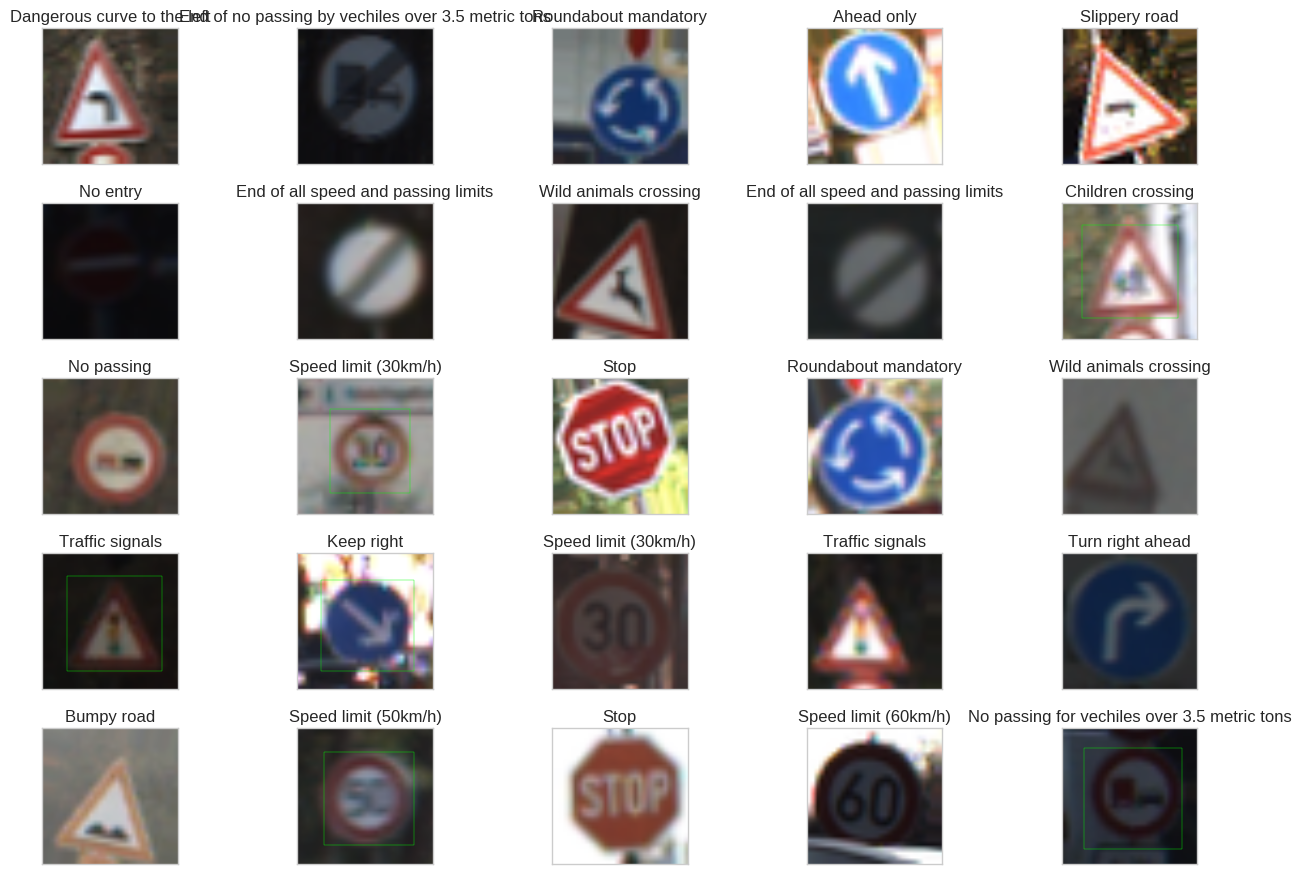

In [14]:
plot_random_train_sign_sample(25)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [15]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [17]:
def conv_max_pool_layer(x, conv_shape, conv_strides=[1,1,1,1],max_pool_strides=[1,2,2,1],ksize=[1,2,2,1], padding='SAME', mu=0,sigma=.1):
    '''a conv2d layer with a max pool layer, returns weights, bias, and result of the operations'''
    #weights
    w = tf.Variable(tf.truncated_normal(conv_shape, mean=mu, stddev=sigma))
    #bias
    b = tf.Variable(tf.zeros(conv_shape[-1]))
    #convolution with relu
    c = tf.nn.relu(tf.nn.conv2d(x,w, strides=conv_strides, padding=padding)+b)
    #max pool it up
    c = tf.nn.max_pool(c,ksize=ksize,strides=max_pool_strides, padding=padding)
    
    return w,b,c
    
    
def model(x):
    mu=0
    sigma=.1
   
    n1= 32
    n2= 64
    n3= 128
    
    #input (?,32,32,3) #output (?,16,16,n1)
    cw1, cb1, c1 = conv_max_pool_layer(x,[5,5,3,n1], mu=mu, sigma=sigma)
    cw2, cb2, c2 = conv_max_pool_layer(c1,[5,5,n1,n2], mu=mu, sigma=sigma)
    cw3, cb3, c3 = conv_max_pool_layer(c2,[5,5,n2,n3], mu=mu, sigma=sigma)
    
    
    #flat
    flat = flatten(c3)
    #print(c3.get_shape())
    
    #fully connected
    hidden_size = 256
    fw1 = tf.Variable(tf.truncated_normal([4*4*n3,hidden_size], mean=mu, stddev=sigma))
    fb1 = tf.Variable(tf.zeros(hidden_size))
    
    h1 = tf.nn.relu( tf.matmul(flat,fw1)+fb1 )
    
    #second fully connected layer
    fw2 = tf.Variable(tf.truncated_normal([hidden_size,hidden_size], mean=mu, stddev=sigma))
    fb2 = tf.Variable(tf.zeros(hidden_size))
    
    h2 = tf.nn.relu( tf.matmul(h1,fw2)+fb2 )
    
    #third fully connected layer
    fw3 = tf.Variable(tf.truncated_normal([hidden_size,n_classes], mean=mu, stddev=sigma))
    fb3 = tf.Variable(tf.zeros(n_classes))
    
    #logits
    h3 = tf.matmul(h2,fw3)+fb3
    
    #return the l2 norm for the convolution weights and the fully connected weights
    l2_loss = sum(map(lambda z: tf.nn.l2_loss(z), [cw1,cw2,cw3,fw1,fw2,fw3]))
    
    return h3, l2_loss
    
    

In [18]:
beta = 1e-3
logits,l2_loss = model(x)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))+beta*l2_loss
optimizer = tf.train.AdamOptimizer()
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
%%time

np.random.RandomState(42)

idx = np.random.permutation(len(y_train))
X_train= X_train[idx]
y_train = y_train[idx]

BATCH_SIZE=128
NUM_EPOCHS=60
EPOCH_SIZE = int(len(X_train)/BATCH_SIZE)

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    feed_dict={}
    for epoch in range(NUM_EPOCHS):
        for i in range(EPOCH_SIZE):
            #sample_idx = np.random.permutation(len(y_train))[:BATCH_SIZE]
            #feed_dict = {x:X_train[sample_idx],y:y_train[sample_idx]}
            feed_dict={x:X_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
                      ,y:y_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]}
            _ = sess.run([training_operation], feed_dict=feed_dict)

        #get the loss and accuracy on our last batch
        loss, acc = sess.run([loss_operation,accuracy_operation], feed_dict=feed_dict)
        #get accuracy on the test set
        accuracy =  sess.run([accuracy_operation], feed_dict={x:X_test, y:y_test})
        print('epoch: {}\tloss: {:.5f}\ttrain_acc: {:.3f}\ttest_acc {:.3f}'.format(epoch,loss,acc,accuracy[0]))

    save_path = saver.save(sess, "models/model.ckpt")
    print("Model saved in file: %s" % save_path)



epoch: 0	loss: 5.50113	train_acc: 0.148	test_acc 0.123
epoch: 1	loss: 4.40955	train_acc: 0.359	test_acc 0.323
epoch: 2	loss: 3.79165	train_acc: 0.492	test_acc 0.481
epoch: 3	loss: 2.82801	train_acc: 0.781	test_acc 0.654
epoch: 4	loss: 2.24211	train_acc: 0.867	test_acc 0.760
epoch: 5	loss: 1.73163	train_acc: 0.945	test_acc 0.836
epoch: 6	loss: 1.46507	train_acc: 0.961	test_acc 0.872
epoch: 7	loss: 1.26375	train_acc: 0.984	test_acc 0.852
epoch: 8	loss: 0.93261	train_acc: 0.984	test_acc 0.904
epoch: 9	loss: 0.68923	train_acc: 1.000	test_acc 0.915
epoch: 10	loss: 0.52189	train_acc: 1.000	test_acc 0.920
epoch: 11	loss: 0.38664	train_acc: 1.000	test_acc 0.922
epoch: 12	loss: 0.31450	train_acc: 0.992	test_acc 0.936
epoch: 13	loss: 0.22845	train_acc: 1.000	test_acc 0.939
epoch: 14	loss: 0.20445	train_acc: 1.000	test_acc 0.948
epoch: 15	loss: 0.18234	train_acc: 1.000	test_acc 0.946
epoch: 16	loss: 0.16847	train_acc: 1.000	test_acc 0.941
epoch: 17	loss: 0.16654	train_acc: 1.000	test_acc 0.945
ep

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I did not do any preprocessing. I thought about normalizing both the colors and sizes, but I wanted the network to be robust to having offcenter images and while a stop sign is red, the color recorded is dependant on lighting conditions so I opted to leave everything alone.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The training and testing sets were loaded from the pickle so I did not modify that split. Do to time constraints I did not engage in any significant hyperparamtere tuning.

I generated alot of fake data, in fact most of my training data was fake. I first wanted to balance the classes in the training data, so I needed to generate. Secondly I wanted the network to be somewhat translation and rotation invariant so I shifted, zoomed, and rotated data. I thought about mirroring, skewing, and adjusting color values aswell but did not have time to implement.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [59]:
tf.reset_default_graph()


with tf.Session() as sess:
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, n_classes)

    logits,l2_loss = model(x)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess,'models/model.ckpt')
    
    print("Model restored.")
    acc = sess.run([accuracy_operation], feed_dict={x:X_test, y:y_test})
    print(acc)


Model restored.
[0.95138609]


In [53]:
!ls models

checkpoint  model.ckpt.data-00000-of-00001  model.ckpt.index  model.ckpt.meta
